In [ ]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

# Create Neural Net

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [75]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils
from collections import deque

env = make("connectx", debug=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)

class ValueNetwork(nn.Module):
    def __init__(self, convFilters, filterSize, boardRows, boardCols):
        """
        Convolutional Layer with ReLU and fully-connected output of one value.
        Args:
            convFilters: number of conv filter
            filterSize: Conv filter size (kernel size)
            boardRows: Number of rows for board
            boardCols: Number of cols for board
        """
        super().__init__()
        self.boardRows = boardRows
        self.boardCols = boardCols
        self.conv_feature_size = (boardRows-filterSize+1) * (boardCols-filterSize+1) * convFilters
        
        self.conv_layer1 = nn.Conv2d(1, convFilters, filterSize)
        self.conv_bn1 = nn.BatchNorm2d(convFilters)
        
        self.fc1 = nn.Linear(self.conv_feature_size, 256)
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, board):
        """
        Args:
            board: serialized board from env observation (-1, 0, 1)
            Current player pieces is 1, opponent player pieces: -1
        Returns:
            The after state value
        """
        board = torch.Tensor(board).to(DEVICE)
        # Reshape
        board = board.view(-1, 1, self.boardCols, self.boardRows)
        s = F.relu(self.conv_bn1(self.conv_layer1(board)))
        
        s = s.view(-1, self.conv_feature_size)
        s = torch.relu(self.fc_bn1(self.fc1(s)))
        s = torch.relu(self.fc_bn2(self.fc2(s)))
        
        output = torch.tanh(self.fc3(s))
        return output


cpu


# Helper functions

In [76]:
def get_valid_actions(env, board):
    return [c for c in range(env.configuration.columns) if board[c] == 0]

def simulate_play(board, column, config):
    EMPTY = 0
    columns = config.columns
    rows = config.rows
    row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
    nextBoard = board.copy()
    # Mark board as player 1
    nextBoard[column + (row * columns)] = 1
    return nextBoard

def policy(env, model, board, returnValue=False):
    """
    Afterstate greedy policy using value network (model)
    
    Returns:
        Best Action OR Best Value.
        
        The best action according to the model by default.
        
        If return value is true, the policy will return the best value.
    """
    bestAction = None
    available_actions = get_valid_actions(env, board)
    afterStates = []
    for action in available_actions:
        afterState = simulate_play(board, action, env.configuration)
        afterStates.append(afterState)
     
    # Return action with best afterstate value
    model.eval()
    with torch.no_grad():
        afterStateValues = model(afterStates)
        bestIndex, bestValue = max(enumerate(afterStateValues), key=(lambda x: x[1]))
        bestAction = available_actions[bestIndex]
    
    if returnValue:
        return bestValue
    
    return bestAction

def training_policy(env, model, board, epsilon):
    """
    Afterstate epsilon greedy policy using value network (model)
    """
    # Explore
    if random.uniform(0, 1) < epsilon:
        available_actions = get_valid_actions(env, board)
        action = random.choice(available_actions)
    # Greedy
    else:
        action = policy(env, model, board)

    return action

def convert_board(board, mark):
    # Converts board into (-1, 0, 1) where current player is 1 and opponent -1
    board = np.array(board)
    for i in range(len(board)):
        if board[i] == 0:
            continue
        elif board[i] == mark:
            board[i] = 1
        else:
            board[i] = -1
    
    return board

def opponent_perspective_board(board):
    return board.copy() * -1

def mean_reward(rewards, agentIndex=0):
    return sum(r[agentIndex] for r in rewards) / float(len(rewards))

def evaluate_agent(agent, opponent_agent_string, episodes):
    
    goingFirst = mean_reward(evaluate("connectx", [agent, opponent_agent_string], num_episodes=episodes//2), 0)
    goingSecond = mean_reward(evaluate("connectx", [opponent_agent_string, agent], num_episodes=episodes//2), 1)
    return (goingFirst + goingSecond) / 2

# Create Agent

In [2]:
# This agent random chooses a non-empty column.
def my_agent(observation, configuration):
    # Number of Columns on the Board: 7
    columns = configuration.columns
    # Number of Rows on the Board: 6
    rows = configuration.rows
    # Number of Checkers "in a row" needed to win: 4
    inarow = configuration.inarow
    # The current serialized Board (rows x columns).
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    
    board = convert_board(board, observation.mark)

    return policy(env, model, board)

# Set up train & experience replay

In [77]:
# Improvements needed
# 1) Normalize loss and value output (DONE)
# 2) Separate model for Pred and Target (DONE)
# 3) Memory replay for more stability (DONE)
# 4) Possibly some rollout methods to look ahead
# 5) Decay in lr or epsilon (DONE)
# 6) Make nn layers more complex (DONE)
def train(model, target_model, optimizer, loss_func, episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay):
    losses = []
    episode_losses = []
    epsilons = []
    win_rates = []
    experience_replay = deque(maxlen=max_exp_size)
    epsilon = epsilon_init
    steps = 0
    for episode in tqdm(range(episodes)):
        # for each episode
        epsilons.append(epsilon)
        env.reset()
        while not env.done:
            steps += 1
            # This is to enable self play
            active = -1
            if env.state[0].status == "ACTIVE":
                active=0
            if env.state[1].status == "ACTIVE":
                active=1
            
            observation = env.state[active].observation
            configuration = env.configuration
            curBoard = convert_board(observation.board, observation.mark)
            
            # Choose epsilon greedy action
            my_action = training_policy(env, model, curBoard, epsilon)
            # Step depending on who's turn is it for self play
            env.step([my_action if i==active else None for i in [0,1]])
            
            after_state_observation = env.state[active].observation
            # After state board
            after_state_board = convert_board(after_state_observation.board, observation.mark)
            
            # Reward
            reward = 0 
            if env.done:
                reward = 1
                            
            # Add to experience replay queue
            experience_replay.append([after_state_board, reward, env.done])
            
            # Update model network every BATCH from experience replay
            if steps % BATCH == 0:
                update_model_from_experience_replay(experience_replay, model, target_model, loss_func, losses)
            
            # Update target network every C_BATCH
            if steps % C_BATCH == 0:
                target_model.load_state_dict(model.state_dict())
        if (episode) % 500 == 500:
            # Run multiple episodes to estimate its performance.
            rewardFirst = mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10))
            rewardSecond = mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10), 1)
            print(f"Trained {episode} episodes, {steps} steps. Going first: {rewardFirst}, going second: {rewardSecond}")
            win_rates.append((rewardFirst + rewardSecond)/ 2)
        episode_losses.append(np.mean(losses[-len(env.steps):]))
        epsilon = max(epsilon * epsilon_decay, epsilon_final)
    # Save weights
    torch.save({
        'model_state_dict': model.state_dict()
    }, MODEL_WEIGHTS_SAVE_PATH)
    print(f"\nTrained total {steps} steps")
    print(f"Last 100 steps loss average: {np.mean(losses[-100:])}")
    plt.plot(episode_losses, label="Episode MSE losses")
    plt.show()
    plt.plot(losses[100:], label="STEP MSE_Loss")
    plt.show()
    plt.plot(epsilons, label="Epsilons")
    plt.show()
    plt.plot(win_rates, label="Win rate against random agent")

def update_model_from_experience_replay(experience_replay, model, target_model, loss_func, losses):
    # Only start training after we have some experiences
    if len(experience_replay) < min_exp_size:
        return
    
    # Set model train, eval
    model.train()
    target_model.eval()
    
    mini_batch = zip(*random.sample(experience_replay, BATCH))
    after_state_boards, rewards, dones = mini_batch
    
    # Use main model to get preds
    preds = model(after_state_boards)
    # Use target model to get targets
    # Simulate next state from opponent's perspective
    with torch.no_grad():
        targets = torch.zeros((BATCH, 1))
        for i in range(len(after_state_boards)):
            after_state_board = after_state_boards[i]
            reward = rewards[i]
            done = dones[i]

            if not done:
                opp_board = opponent_perspective_board(after_state_board)
                nextMaxValue = policy(env, target_model, opp_board, returnValue=True)
                # Negative value since, it would be the value of the opponent (zero sum game)
                targets[i] = (nextMaxValue * gamma) *-1
            else:
                targets[i] = torch.as_tensor(reward).to(DEVICE)
    # Minibatch update
    loss = loss_func(preds, targets)
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() 
    
# Set up model and optimizer
MODEL_WEIGHTS_SAVE_PATH = './model_weights.pt'
numConvFilters = 32
filterSize = 4
# Create model and target model
# Input: after board state, player mark
# Output: Value of the after boardstate
# Model: main model updated every BATCH
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
#model.load_state_dict(torch.load(MODEL_WEIGHTS_SAVE_PATH)['model_state_dict'])
# Target model: updated every C_BATCH
target_model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
target_model.load_state_dict(model.state_dict())

# Cast model to cuda
model = model.to(DEVICE)
target_model = model.to(DEVICE)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
epsilon_init = 1.0
epsilon_final = 0.01
epsilon_decay = 0.999
episodes = 5000
gamma = 0.99
# Steps to update model
BATCH = 64
# Steps to update target model
C_BATCH = BATCH * 10
# Experience replay min size to train
min_exp_size = BATCH * 10
max_exp_size = BATCH * 100

In [68]:
state1 = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,1],
         [0,0,0,0,0,0,-1],
         [0,0,1,0,0,0,-1],
         [0,0,1,0,1,0,-1],]
state2 = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,-1,1,0,-1,0,1],]
state1 = np.array(state1).reshape(-1)
state2 = np.array(state2).reshape(-1)
model.eval()
after_state_value = model(np.array([state1, state2]))
print(after_state_value)

tensor([[ 0.1906],
        [-0.2013]], grad_fn=<TanhBackward0>)


100%|███████████████████████████████████████| 5000/5000 [05:49<00:00, 14.29it/s]



Trained total 79776 steps
Last 100 steps loss average: 0.03884368394501507


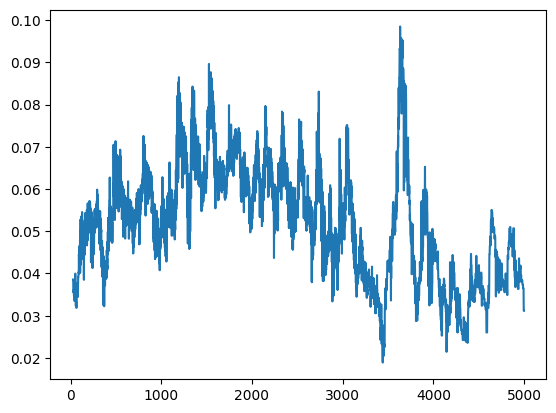

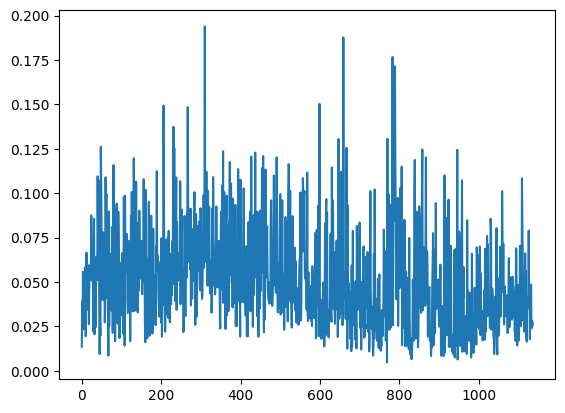

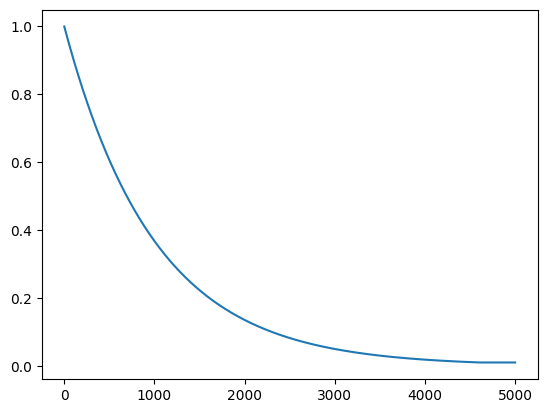

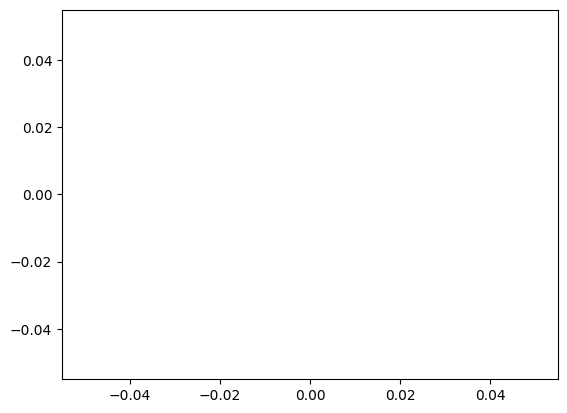

In [78]:
# Start Training
train(model, target_model, optimizer, nn.MSELoss(), episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay)

In [ ]:
# Load Model
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
#model.load_state_dict(torch.load(MODEL_WEIGHTS_SAVE_PATH, map_location=torch.device('cpu'))['model_state_dict'])

# Test Agent

In [79]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, "random"])
env.render(mode="ipython", width=500, height=450)

# Evaluate your Agent

In [80]:
print(evaluate_agent(my_agent, "random", 100))
#print(evaluate_agent(my_agent, "negamax", 100))

0.6799999999999999


# Play your Agent
Click on any column to place a checker there ("manually select action").

In [81]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([my_agent, None], width=500, height=450)

# Write Submission File



In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.